In [1]:
import numpy as np
import pandas as pd
import torch
import sklearn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as du
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.manifold import TSNE
from tqdm import tqdm
from torch.utils import data
from collections import defaultdict
from torch.utils.data import Dataset
from torchvision import datasets, transforms

Exploratory Data Analysis for Students and Tutors

In [2]:
url_student = 'https://raw.githubusercontent.com/Instantutor/Instantutor-Research/main/Datasets/Data.csv'
student = pd.read_csv(url_student)
student.head()

,id_student,gender,Category(Mentor/Mentee/Both),Area,Degree,Course,Time zone,Availability time start,Availability time end
0,11391,M,1,IT,Undergraduate,NaN,Asia,9:00,14:00
1,28400,F,3,IT,Graduate,NaN,Pacific,16:00,18:00
2,30268,F,2,IT,PhD,NaN,Europe,12:00,15:00
3,31604,F,1,IT,PhD,NaN,Central,14:00,23:00
4,32885,F,3,IT,Undergraduate,NaN,Europe,20:00,23:00


In [3]:
student.drop(['Category(Mentor/Mentee/Both)', 'Degree', 'Course'], axis = 1, inplace = True)
student.head()

,id_student,gender,Area,Time zone,Availability time start,Availability time end
0,11391,M,IT,Asia,9:00,14:00
1,28400,F,IT,Pacific,16:00,18:00
2,30268,F,IT,Europe,12:00,15:00
3,31604,F,IT,Central,14:00,23:00
4,32885,F,IT,Europe,20:00,23:00


In [4]:
url_rating = 'https://raw.githubusercontent.com/Instantutor/Instantutor-Research/main/Datasets/Rating.csv'
rating = pd.read_csv(url_rating)
rating.head()

,Mentor,Mentee,Rating,Comments,Time stamp
0,366449,NaN,1.0,NaN,1425941529
1,1677677,NaN,4.5,NaN,1425942435
2,553755,NaN,5.0,NaN,1425941523
3,611182,NaN,5.0,NaN,1425941546
4,646184,NaN,5.0,NaN,1425941556


In [5]:
rating.drop(['Mentee', 'Time stamp', 'Comments'], axis = 1, inplace = True)
rating.head()

,Mentor,Rating
0,366449,1.0
1,1677677,4.5
2,553755,5.0
3,611182,5.0
4,646184,5.0


In [6]:
print(student['Area'].value_counts())
print(student['Time zone'].value_counts())

Area
IT                      3338
Chemistry               3299
Math                    3265
Chemical Engineering    3231
Materials Science       3182
History                 3155
Geology                 3151
Computer Science        3133
Aerospace               3131
Physics                 3114
French                   130
Arabic                   118
Science                  102
English                   90
Biology                   60
Spanish                   50
Quran                     44
Name: count, dtype: int64
Time zone
Asia             4162
Europe           4096
Africa           4095
Australia        4082
Pacific          4064
North America    4040
Central          4034
Antarctica       4020
Name: count, dtype: int64


In [7]:
possible_areas = student['Area'].unique()
possible_zones = student['Time zone'].unique()
possible_times = ["0:00", "1:00", "2:00", "3:00", "4:00", "5:00", "6:00", "7:00", "8:00", "9:00", "10:00", "11:00", 
                  "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"] 
possible_genders = ['F', 'M']

student_rows = student['Area'].size
rating_rows = rating['Mentor'].size
spreads = student['Area'].value_counts()
distribution = spreads.div(student_rows)
print(distribution)

Area
IT                      0.102415
Chemistry               0.101218
Math                    0.100175
Chemical Engineering    0.099132
Materials Science       0.097628
History                 0.096800
Geology                 0.096677
Computer Science        0.096125
Aerospace               0.096064
Physics                 0.095542
French                  0.003989
Arabic                  0.003620
Science                 0.003130
English                 0.002761
Biology                 0.001841
Spanish                 0.001534
Quran                   0.001350
Name: count, dtype: float64


In [8]:
rating['gender'] = np.random.choice(possible_genders, rating_rows)
rating['Area'] = np.random.choice(possible_areas, rating_rows, p = distribution.values)
rating['Time zone'] = np.random.choice(possible_zones, rating_rows)
rating['Availability time start'] = np.random.choice(possible_times, rating_rows)
rating['Availability time end'] = np.random.choice(possible_times, rating_rows)
rating.head()

,Mentor,Rating,gender,Area,Time zone,Availability time start,Availability time end
0,366449,1.0,F,Math,Pacific,4:00,6:00
1,1677677,4.5,F,French,Australia,11:00,9:00
2,553755,5.0,M,History,Australia,17:00,11:00
3,611182,5.0,M,English,Australia,0:00,8:00
4,646184,5.0,F,IT,Europe,22:00,16:00


In [9]:
mentor_to_rating = rating.groupby('Mentor')['Rating'].apply(list).to_dict()
rating.drop('Rating', axis = 1, inplace = True)

We will use a classification task to train our embeddings. To do so, we will create positive pairs using collaborative filtering
and randomly sampled negative pairs. For each user, we want to create 3 positive samples and 15 negative samples. We can choose to pass these as batches.

In [10]:
gender_to_val = {possible_genders[i]:i for i in range(len(possible_genders))}
area_to_val = {'IT' : 0, 'Computer Science': 3, 'Math': 9, 'Physics': 11 ,'Aerospace': 13,
               'Science': 20, 'Chemical Engineering': 24, 'Materials Science': 29,
               'Biology': 30, 'Chemistry': 24, 'Geology': 45,
               'English': 68, 'French': 77, 'Spanish': 82,
               'Arabic': 88, 'Quran': 95, 'History': 110}
time_to_val = {'Asia': 0, 'Europe': 20, 'Africa': 40, 'Australia': 60, 'Antarctica': 70, 'North America': 80, 'Central': 90, 'Pacific': 100}
avail_to_val = {possible_times[i]:i  for i in range(len(possible_times))}

In [11]:
student = student.replace(gender_to_val)
student = student.replace(area_to_val)
student = student.replace(time_to_val)
student = student.replace(avail_to_val)
student.head()

,id_student,gender,Area,Time zone,Availability time start,Availability time end
0,11391,1,0,0,9,14
1,28400,0,0,100,16,18
2,30268,0,0,20,12,15
3,31604,0,0,90,14,23
4,32885,0,0,20,20,23


In [12]:
rating = rating.replace(gender_to_val)
rating = rating.replace(area_to_val)
rating = rating.replace(time_to_val)
rating = rating.replace(avail_to_val)
rating.head()

,Mentor,gender,Area,Time zone,Availability time start,Availability time end
0,366449,0,9,100,4,6
1,1677677,0,77,60,11,9
2,553755,1,110,60,17,11
3,611182,1,68,60,0,8
4,646184,0,0,20,22,16


In [13]:
duplicate_users = student[student.duplicated(subset = 'id_student', keep = 'first')]
duplicate_tutors = rating[rating.duplicated(subset = 'Mentor', keep = 'first')]
student.drop(index = duplicate_users.index, inplace = True)
rating.drop(index = duplicate_tutors.index, inplace = True)

list_tutors = rating['Mentor'].tolist()
list_users = student['id_student'].tolist()

# Create reverse mappings for users and tutors
idx_to_user = {index: user for (index, user) in enumerate(list_users)}
user_to_idx = {user: index for (index, user) in enumerate(list_users)}
idx_to_tutor = {index: tutor for (index, tutor) in enumerate(list_tutors)}
tutor_to_idx = {tutor: index for (index, tutor) in enumerate(list_tutors)}

In [14]:
final_user = student.drop('id_student', axis = 1, inplace = False)
final_tutor = rating.drop('Mentor', axis = 1, inplace = False)

Then, we can generate positive and negative samples through collaborative filtering.
When selecting positive samples, cosine similarity will be weighted based on the following adjustable criteria:
* Gender: 5%
* Area: 70%
* Time Zone: 10%
* Availability Time Start: 10%
* Availability Time End: 5%

In [15]:
weights = [0.03, 0.72, 0.15, 0.05, 0.05]

def weighted_Norm(user, tutor, weights):
    '''
    Calculate a weighted euclidean distance given a user and a tutor.
    '''
    dist = user-tutor
    weighted_dist = np.sqrt(np.dot(weights,np.dot(dist, dist)).sum())
    return weighted_dist

In [16]:
class UserTutorDataset(torch.utils.data.IterableDataset):
    def __init__(self, pos_samples, neg_samples, users, tutors, weights):
        '''
        pos_samples - The number of positive samples to create per user.
        neg_samples - The number of negative samples to create per user.
        users - A dataset consisting of users and their attributes(gender, area, timezone, availability times).
        tutors - A dataset consisting of tutors and their attributes.
        weights - An array-like of weights for each attribute of a user/tutor. This gives us more information on which attributes are more important.
        '''
        super(UserTutorDataset, self).__init__()
        
        self.pos_samples = pos_samples
        self.neg_samples = neg_samples
        self.users = users
        self.tutors = tutors
        self.weights = weights
        
        # precompute all distances       
        self.dists = {user_idx:[weighted_Norm(self.users[user_idx], tutor, self.weights) for tutor in self.tutors] for user_idx in tqdm(range(len(self.users)))}
        
    def get_pairs(self, user):
        ''' given a user, generate positive and negative pairs for that user '''
        
        distances = self.dists[user]
        pos_pairs = np.argpartition(distances, self.pos_samples)[:self.pos_samples]
        
        min_five = np.argpartition(distances, -500)[-500:]
        neg_pairs = np.random.choice(min_five, self.neg_samples)
        
        labels = np.zeros(self.pos_samples + self.neg_samples)
        labels[0:self.pos_samples] = 1
                               
        return pos_pairs, neg_pairs, labels
        
    def __len__(self):
        return len(self.users)
    
    def __iter__(self):
        """
        Returns a tensor of positve and negative tutor samples along with targets for a given index as a generator.
        """
                
        for idx in range(len(self.users)):
            pos_pairs, neg_pairs, labels = self.get_pairs(idx)
            pos_pairs = torch.tensor(pos_pairs)
            neg_pairs = torch.tensor(neg_pairs)
            total_pairs = torch.cat((pos_pairs, neg_pairs), dim = 0)

            labels = torch.tensor(labels)
            targets = torch.full(total_pairs.shape, idx)
            
            yield targets, total_pairs, labels

In [17]:
class TwoTower(nn.Module):
    ''' Two-Tower Recommender System '''
    
    def __init__(self, num_user, user_features, num_tutors, tutor_features, in_dim, hidden_dim, out_dim):
        super(TwoTower, self).__init__()
        self.user_embedding = nn.Embedding(num_user, user_features)
        self.tutor_embedding = nn.Embedding(num_tutors, tutor_features)
        
    def forward(self, user_idx, tutor_idx):
        embed_u = self.user_embedding(user_idx)
        embed_t = self.tutor_embedding(tutor_idx)
        return torch.sum(embed_u * embed_t, dim = 2)

Begin the classification task to train the embeddings

In [18]:
POS_SAMPLES = 5
NEG_SAMPLES = 18
IN_DIM = 5
HIDDEN_DIM = 128
OUT_DIM = POS_SAMPLES * NEG_SAMPLES
EPOCHS = 10
LEARNING_RATE = 0.05
BATCH_SIZE = 1
THRESHOLD = 0.7

users = final_user.to_numpy()
tutors = final_tutor.to_numpy()
feat_weights = weights
num_users = final_user.shape[0]
num_tutors = final_tutor.shape[0]
num_user_features = final_user.shape[1]
num_tutor_features = final_tutor.shape[1]

In [19]:
# Pick the device
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cpu


In [20]:
train_data = UserTutorDataset(POS_SAMPLES, NEG_SAMPLES, users, tutors, feat_weights)

100%|████████████████████████████████████████████████████████████████████████████| 28785/28785 [21:14<00:00, 22.59it/s]


In [31]:
train_loader = du.DataLoader(dataset = train_data, batch_size = BATCH_SIZE)

model = TwoTower(num_users, num_user_features, num_tutors, 
                 num_tutor_features, IN_DIM, HIDDEN_DIM, OUT_DIM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

model = model.to(device)
model.train()

TwoTower(
  (user_embedding): Embedding(28785, 5)
  (tutor_embedding): Embedding(3607, 5)
)

In [32]:
loss_func = nn.BCEWithLogitsLoss()

for epoch in range(1, EPOCHS+1):
    sum_loss = 0.
    for batch_idx, (targets, total_pairs, labels) in enumerate(tqdm(train_loader)):
        targets, total_pairs, labels = targets.to(device), total_pairs.to(device), labels.to(device)
        
        model.zero_grad()
        
        prediction = model(targets, total_pairs)
        loss = loss_func(prediction, labels.float())
        sum_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    sum_loss /= (len(train_loader) * 15)
    print(f"Epoch: {epoch}/{EPOCHS}, Loss: {sum_loss:.6f}")

100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:32<00:00, 310.11it/s]


Epoch: 1/10, Loss: 0.073153


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:20<00:00, 358.28it/s]


Epoch: 2/10, Loss: 0.074118


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:43<00:00, 277.52it/s]


Epoch: 3/10, Loss: 0.045604


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:17<00:00, 373.09it/s]


Epoch: 4/10, Loss: 0.032424


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:24<00:00, 340.80it/s]


Epoch: 5/10, Loss: 0.025782


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:22<00:00, 348.10it/s]


Epoch: 6/10, Loss: 0.015486


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:26<00:00, 331.98it/s]


Epoch: 7/10, Loss: 0.007335


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:44<00:00, 275.46it/s]


Epoch: 8/10, Loss: 0.002899


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:50<00:00, 260.95it/s]


Epoch: 9/10, Loss: 0.001320


100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [01:57<00:00, 245.96it/s]

Epoch: 10/10, Loss: 0.000530


Overfitting can actually be leveraged since we don't plan to address any new users, who are matched using collaborative filtering.

In [41]:
SAVE = True
LOAD_PREV = False

if SAVE:
    torch.save(model, "user_tutor_embed.pth")

if LOAD_PREV:
    model = torch.load("user_tutor_embed.pth")
    model.train()

In [34]:
def visualize_embeddings(embeddings, feature, rating, embedding_dim, mode):
    '''
    Given a learned embedding, a dataframe, and the feature to display by, 
    display a tsne-visualization of the embeddings and then 
    the embeddings by feature if feature is not none.
    '''
    
    # Reduce the embeddings to 2 dimensions using a manifold.
    reduced_embedding = TSNE(3, perplexity = 50, learning_rate = 'auto').fit_transform(embeddings)
    
    plt.figure(figsize = (12.4,9.92))
    plt.plot(reduced_embedding[:, 0], reduced_embedding[:, 1], reduced_embedding[:,2], '.g')
    if mode == 'User':
        plt.title("User Embeddings")
    else:
        plt.title("Tutor Embeddings")
    plt.show()
    
    
    if feature != 'None' and feature in rating.columns:
        # Obtain all labels for that feature
        plt.figure(figsize = (18,12))
        all_labels = rating[feature]
        color_labels, unique_feats  = pd.factorize(all_labels)
        
        new_colors = plt.cm.tab20(np.linspace(0.1, 1.0, 17))
        new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", new_colors)

        plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], reduced_embedding[:,2],
                    c = color_labels, cmap = new_cmap)
        
        # Display a key on the side
        color_bar = plt.colorbar()
        color_bar.set_ticks([])
        
        for idx, feats in enumerate(unique_feats):
            color_bar.ax.text(1, (2 * idx + 1)/((10)*2), feats, ha = 'left', va = 'center')
        color_bar.ax.set_title(feature, loc = 'left')
        plt.xlabel("Embedding Axis 1")
        plt.ylabel("Embedding Axis 2")
        
        if mode == 'User':
            plt.title("Colored User Embeddings")
        else:
            plt.title("Colored Tutor Embeddings")
        
        plt.show()

In [35]:
for name, p in model.named_parameters():
    if name == 'user_embedding.weight':
        user_embeddings = p.cpu().data.numpy()
    if name == 'tutor_embedding.weight':
        tutor_embeddings = p.cpu().data.numpy()

Visualize Embeddings in 3D

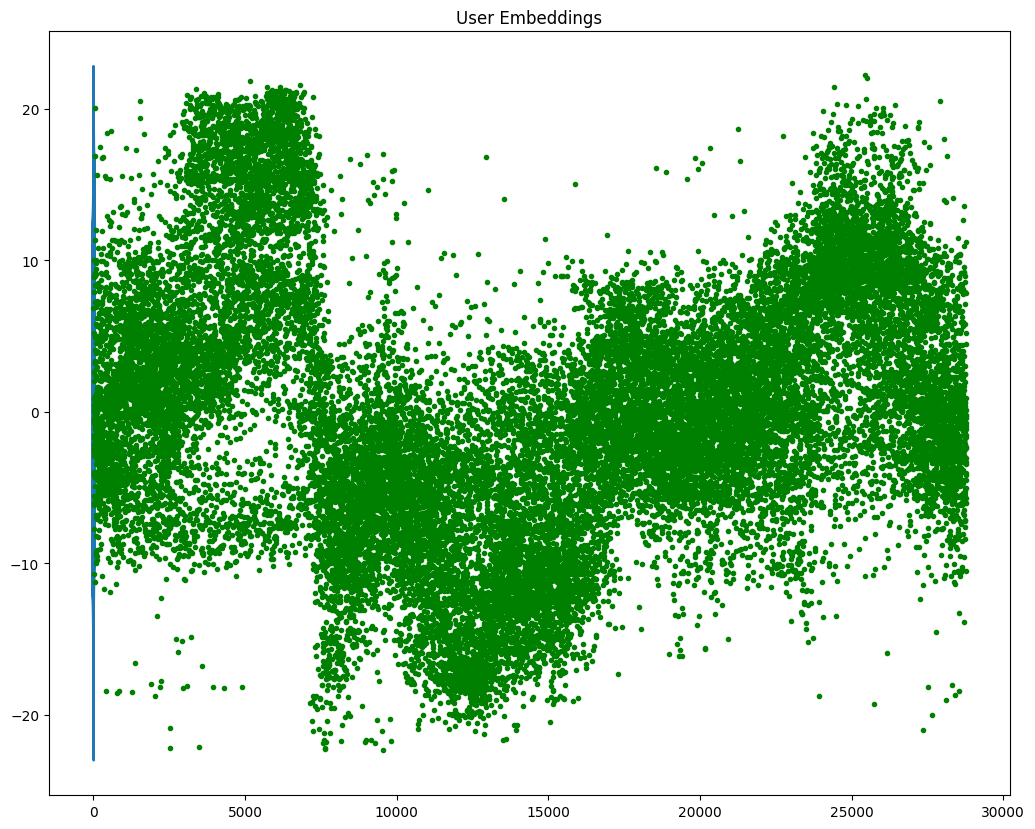

c:\users\qiud.laptop-93u1jskv\appdata\local\programs\python\python38\lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


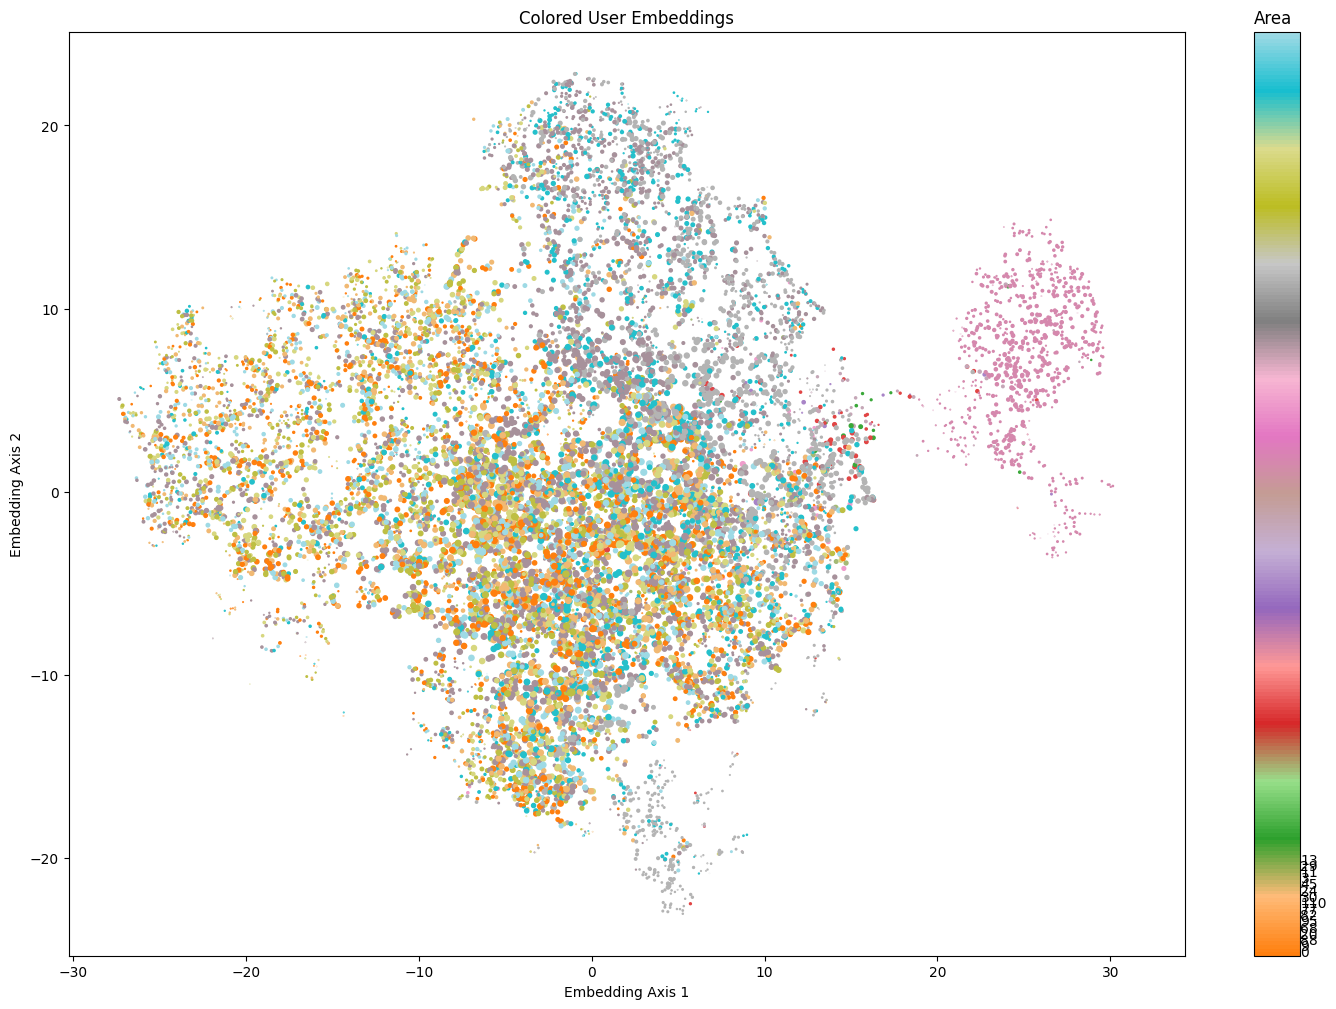

In [36]:
visualize_embeddings(user_embeddings, 'Area', student, num_user_features, 'User')

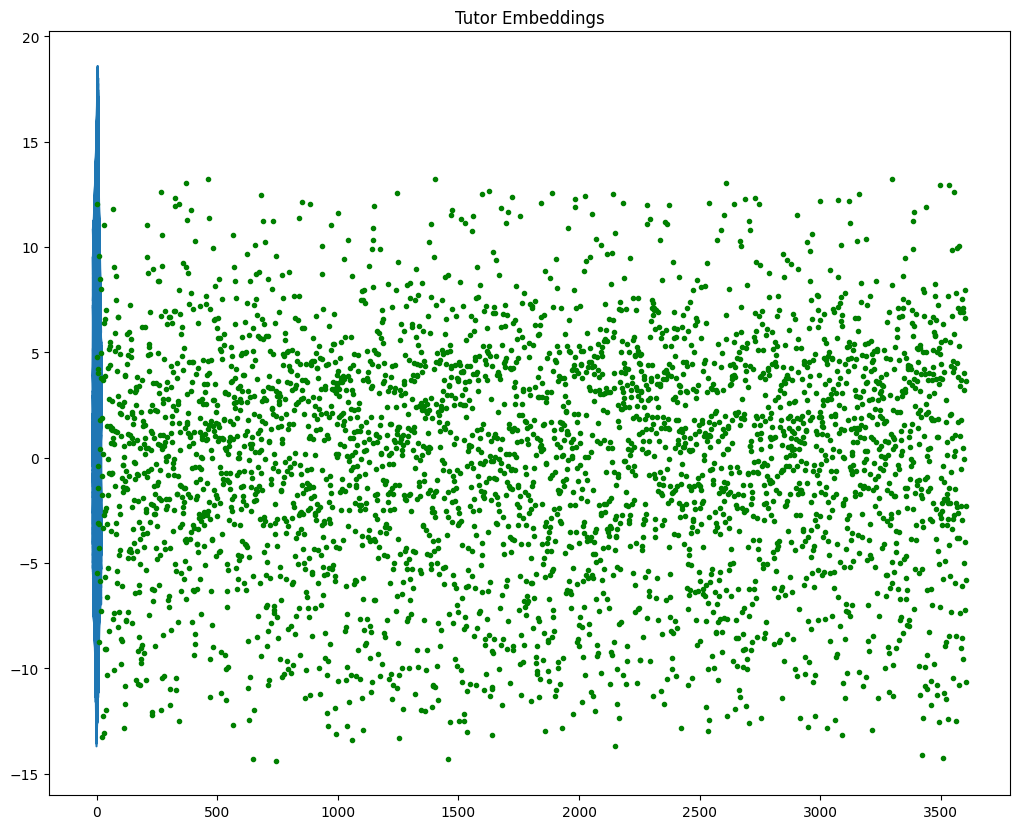

c:\users\qiud.laptop-93u1jskv\appdata\local\programs\python\python38\lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


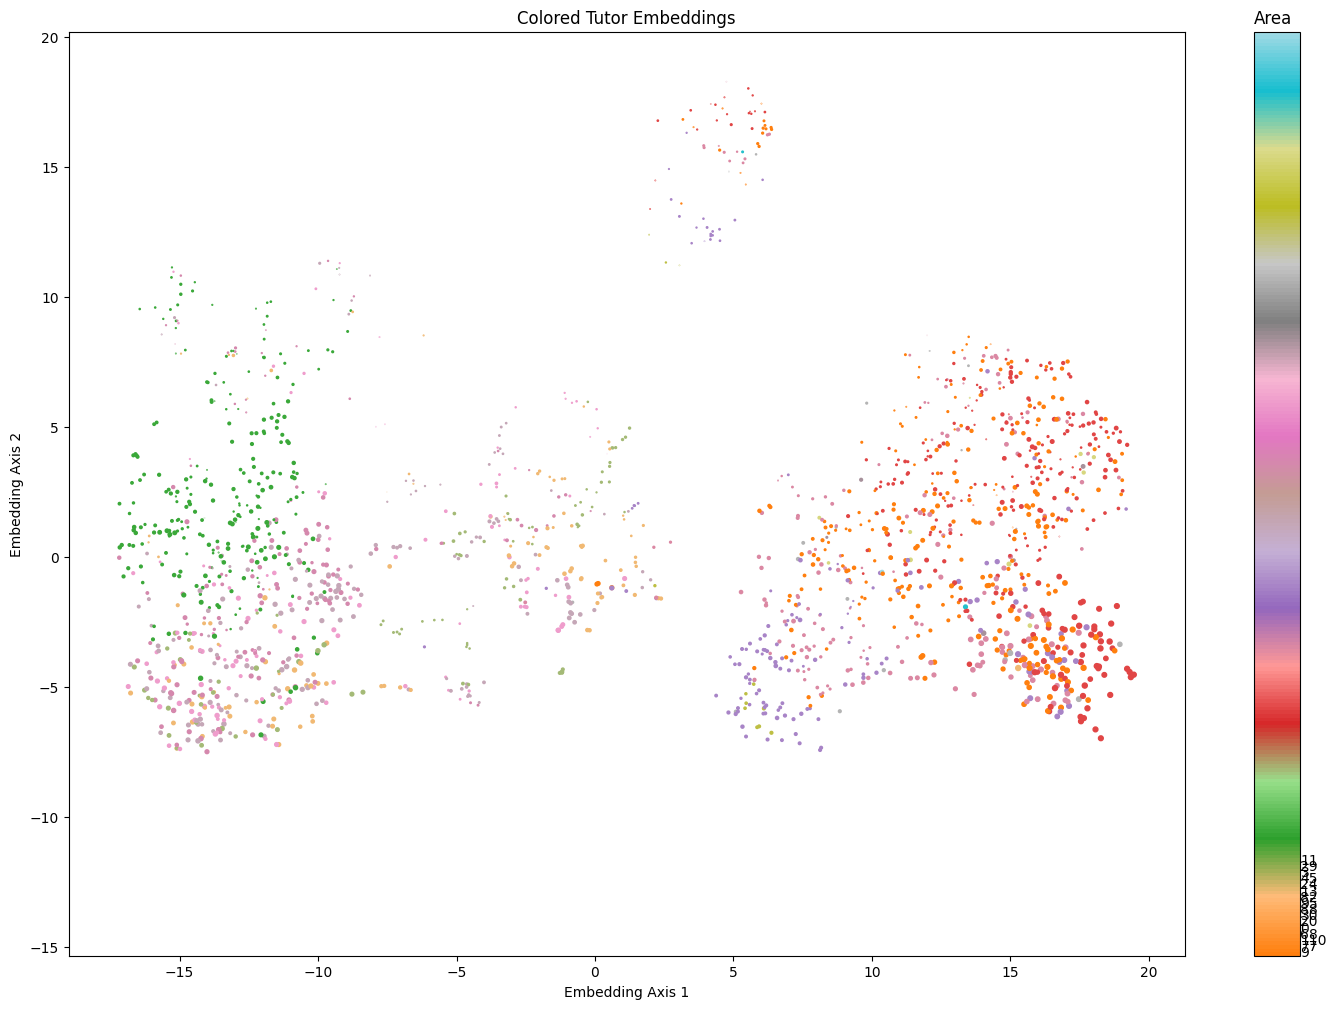

In [37]:
# Visualize tutor embeddings
visualize_embeddings(tutor_embeddings, 'Area', rating, num_tutor_features, 'Tutor')

Implement K-NN to recommend users tutors

In [38]:
def KNN(user, embeddings, k, students, idx_to_user):
    """
    Finds and returns the k nearest neighbors of the given user from the embeddings.
    user: the index of the user
    embeddings: the learned weights of all the users(must include user)
    k: the nubmer of nearest neighbors to find.
    ratings: a mapping of idx to a user's features
    idx_to_user: a mapping of indicies to user id
    """
    # Calculate all distances using cosine similarity making sure to check for user validity
    try:
        p1 = embeddings[user] @ embeddings.T
        p2 = np.linalg.norm(embeddings[user]) * np.linalg.norm(embeddings.T, axis = 0)
        n_dists = p1/p2
        n_dists = n_dists.T
    except KeyError:
        print("This user has yet to learn an embedding in the system.")
        return False
    
    # Find the closest k indicies for each user.
    sorted_dists = np.argsort(n_dists, axis = -1)[:k]
    
    # Retrieve user ids and ratings
    ids = [idx_to_user[u] for u in sorted_dists]
    id_feats = [students.loc[students["id_student"] == iden].to_numpy() for iden in ids]
        
    # Retrieve and return the features of the recommended users
    return {U:F for U, F in zip(ids, id_feats)} 

In [63]:
def c_dist(v_1, v_2, weights):
    p1 = np.dot(v_1, v_2 * weights)
    p2 = np.linalg.norm(v_1) * np.linalg.norm(v_2)
    return p1/p2

#### Evaluate the Model on the Training Set
While this normally wouldn't fly, our goal is to cater to concurrent, pre-existing users and not to generalize on any new users. New users will be recommended based on collaborative filtering alone.

In [68]:
model.eval()
NUM_GUESS = 3
TOTAL_SAMPLE = NUM_GUESS * len(train_loader.dataset)
THRESHOLD = 0.3
num_corr = 0

for batch_idx, (targets, total_pairs, labels) in enumerate(tqdm(train_loader)):
    targets, total_pairs, labels = targets.to(device), total_pairs.to(device), labels.to(device)
    target_user = targets[:,0]
    prediction = KNN(target_user.squeeze(), user_embeddings, NUM_GUESS, student, idx_to_user)
    
    u_id = idx_to_user[target_user.numpy()[0]]
    u_feat = student.loc[student["id_student"] == u_id].to_numpy()[0][1:]
    
    for p in prediction: 
        distance = c_dist(u_feat, prediction[p][0][1:], weights)
        num_corr += (distance < THRESHOLD).sum()
    
print(f"Correct: {num_corr}, Total: {len(train_loader.dataset) * NUM_GUESS}, Accuracy: {num_corr/TOTAL_SAMPLE}")

100%|███████████████████████████████████████████████████████████████████████████| 28785/28785 [03:02<00:00, 157.51it/s]

Correct: 66851, Total: 86355, Accuracy: 0.7741416246887847
